## Analyzing refractive index of vinyl chloride in water
___
**Philip J**\
**Date Updated: 31-10-20223**

### Setup

**Libraries**


In [4]:
import matplotlib.pyplot as plt     # For plots
import numpy as np                  # Numpy for working with numbers
import pyspectroworks               # API interface with Spectroworks
from datetime import datetime       # For handling dates and times.
import re                           # Regular expressions

Connecting to the pyspectroworks api

In [5]:
api_key = "ZWZhMWQ1MTQtOGM4MS00YzI1LWJiY2UtNTg3YWY1MGI5ZmQ0"
conn = pyspectroworks.connect(api_key)

Accessing the information about the project.

In [6]:
projects = conn.get_projects()      # Loading all the projects

project = projects[0]               # This is the main project.
items = project.get_items()

Getting the Test number *(T#)* and the Time value from the Sample name

In [7]:
def get_test_number(item_input):
    try:
        sample_name = item_input.sample_attributes['Sample name']
    except KeyError:
        return

    test_number = re.findall(r'T\d+', sample_name)
    if test_number:
        return int(test_number[0][1:])
    else:
        return 'N/A'

def get_measurement_time(item_input):
    try:
        sample_name = item_input.sample_attributes['Sample name']
    except KeyError:
        return
    
    measurement_time = re.findall(r'\d+\.?\d*min', sample_name)
    if measurement_time:
        return float(measurement_time[0][:-3])
    else:
        return 'N/A'
    
def is_water_reference(item_input):
    try:
        sample_name = item_input.sample_attributes['Sample name']
    except KeyError:
        return
    
    water_reference = True if re.findall(r'water reference', sample_name.lower()) else False 
    return water_reference


Looking at the data in the items.

In [8]:
print('{: >6} {:>32} {: >24}'.format('Index', 'Name', 'Created'))
for i, item in enumerate(items):
    try:
        sample_name = item.sample_attributes['Sample name']
    except KeyError:
        sample_name = "N/A"

    timestamp = datetime.utcfromtimestamp(item.created).strftime('%d-%m-%Y %H:%M:%S')
    print('{: >6} {: >32} {: >24}'.format(i, sample_name, timestamp))

 Index                             Name                  Created
     0     T1 Water reference 1 (14:50)      21-09-2023 12:50:41
     1                      T1 00min VC      21-09-2023 13:30:53
     2                      T1 05min VC      21-09-2023 14:00:51
     3                      T1 10min VC      21-09-2023 14:03:16
     4                      T1 15min VC      21-09-2023 14:08:50
     5                      T1 20min VC      21-09-2023 14:14:01
     6                      T1 25min VC      21-09-2023 14:17:53
     7                      T1 30min VC      21-09-2023 14:23:15
     8                     T1 35min VC       21-09-2023 14:27:21
     9                      T1 40min VC      21-09-2023 14:32:11
    10                      T1 45min VC      21-09-2023 14:38:09
    11                      T1 50min VC      21-09-2023 14:42:58
    12                      T1 55min VC      21-09-2023 14:47:45
    13                      T1 60min VC      21-09-2023 14:52:38
    14            T2 Wate

C:\Users\phili\AppData\Local\Temp\ipykernel_29012\3665817024.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  timestamp = datetime.utcfromtimestamp(item.created).strftime('%d-%m-%Y %H:%M:%S')


### Plotting the standard spectra

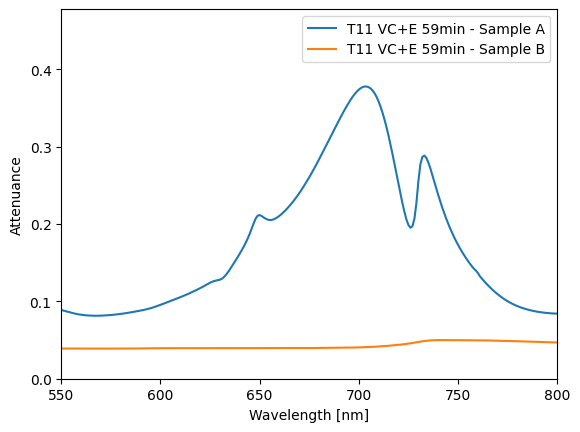

In [23]:
try:                                                                        # Trying to get the sample name, if it is empty put N/A
    sample_name = item.sample_attributes['Sample name']
except KeyError:
    sample_name = "N/A"

sample_spectrum = np.array(item.get_spectrum('sample_B'))
plt.plot(sample_spectrum[:, 0], sample_spectrum[:, 1], label=f"{sample_name} - Sample A")   # Plotting the spectrum
y_max = max(sample_spectrum[:, 1])

sample_spectrum = np.array(item.get_spectrum('sample_A'))
plt.plot(sample_spectrum[:, 0], sample_spectrum[:, 1], label=f"{sample_name} - Sample B")   # Plotting the spectrum

plt.xlim([min(sample_spectrum[:,0]), 800])
plt.ylim(0.0, y_max+0.1)
# plt.ylim(0.0, 4.0)
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Attenuance')
plt.show()

Combining the refractive index values for the different tests *(T#)*

In [25]:
analyze_test_number = 11

refractive_index = [[]]
time = []
for i, item in enumerate(items):
    try:
        sample_name = item.sample_attributes['Sample name']
    except KeyError:
        sample_name = 'N/A'

    if get_test_number(item) == analyze_test_number and not is_water_reference(item):
        refractive_index.append((item.results.get('refractive_index', {})).get('value', 'N/A'))
        time.append((get_measurement_time(item)))
        analyte = item.sample_attributes['Analyte']
        solvent = item.sample_attributes['Solvent']
    

refractive_index = refractive_index[1:]
ri_std_deviation = np.std(refractive_index)
ri_mean = np.mean(refractive_index)
ri_no_outliers = []
time_no_outliers = []

for i, ri in enumerate(refractive_index):
    if ri > ri_mean + 2*ri_std_deviation or ri < ri_mean - 2*ri_std_deviation:
        continue
    else:
        ri_no_outliers.append(ri)
        time_no_outliers.append(time[i])

Getting the different properties of the measurement from the data\
All the information is written in the *sample attributes*, and then I am using regular expressions to get those values.

In [26]:
vc_volume = float(re.findall(r'\d+\.*\d*ul', analyte)[0][:-2]) # ul
di_volume = float(re.findall(r'\d+\.*\d*ml',solvent)[0][:-2]) # ml

vc_source_concentration = 2000 # ug/ml in methanol -> 2ug/ul

vc_concentration = (vc_volume*vc_source_concentration/1000)/di_volume # ug/ml

Plotting the refractive index against time

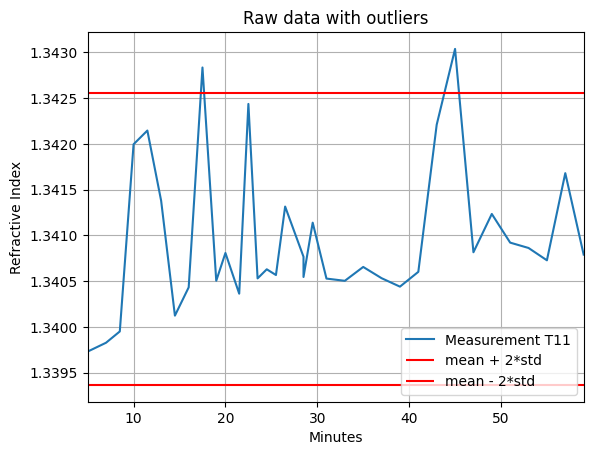

In [27]:
fig, ax = plt.subplots()

ax.plot(time, refractive_index, label=f"Measurement T{analyze_test_number}")
ax.hlines(y=ri_mean+2*ri_std_deviation, xmin=min(time), xmax=max(time), color='r', label=f"mean + 2*std")
ax.hlines(y=ri_mean-2*ri_std_deviation, xmin=min(time), xmax=max(time), color='r', label=f"mean - 2*std")

plt.legend()
plt.grid(True)
plt.xlim(min(time), max(time))
plt.title("Raw data with outliers")
plt.xlabel("Minutes")
plt.ylabel("Refractive Index")

plt.show()

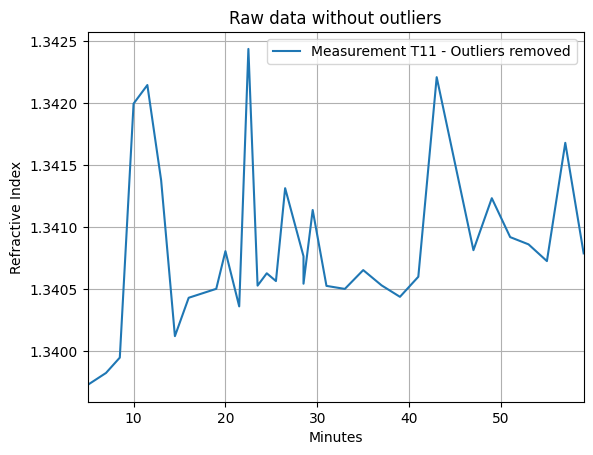

In [28]:
fig, ax = plt.subplots()

ax.plot(time_no_outliers, ri_no_outliers, label=f"Measurement T{analyze_test_number} - Outliers removed")

plt.legend()
plt.grid(True)
plt.xlim(min(time), max(time))
plt.title("Raw data without outliers")
plt.xlabel("Minutes")
plt.ylabel("Refractive Index")

plt.show()

The RI shift and properties of the measurement

In [29]:
ri_shift = max(ri_no_outliers) - ri_no_outliers[0]

print(
f'''
RI Shift:\t\t{ri_shift}
Analyte:\t\t{analyte}
Vinyl Chloride volume:\t{vc_volume} ul
DI water volume:\t{di_volume} ml
VC Concentration:\t{(float(vc_volume)*2)/float(di_volume)} ug/ml
'''
)


RI Shift:		0.00270683750717593
Analyte:		VC 7.5ul + Enzyme
Vinyl Chloride volume:	7.5 ul
DI water volume:	3.0 ml
VC Concentration:	5.0 ug/ml

